![McLaren Maze Race Banner](media/banner.png)

# Welcome to Learner Driver - Level 1 of the McLaren Maze Race! 

In this level we will build a basic artificial intelligence (AI) that can drive our simulated F1 car whilst introducing the foundations of the Maze Race Challenge. 

### Introduction to notebooks

First up, a short introduction to Jupyter notebooks (which this is). If you are already familiar with them, skip to the next heading. Jupyter notebooks like this consist of sections of text (like this one) and sections of code (like the one below). You can just read the whole notebook without running anything (hopefully all the figures are populated below). You will miss out on seeing the AI learn however! To run the sections of code, click on the little black arrow at the top left of each section. **NB: the code sections are all related to each other and need to be run in order.** 

For the best experience, read each text section and run each code section as you move down the page. If you try and run a later piece of code without running the ones above then you might hit an error. If that happens go back and run the cells above. You can reset everything by using the "Restart Kernel" option up on the top toolbar. If you get stuck there should be plenty of help articles around online or you can contact us using [this form](https://forms.office.com/Pages/ResponsePage.aspx?id=1D5YJvyfwkadGvDKNaMKjclg_cyBBFJPg8x5VJ87DGJUNlNFTlVHS05LTUpKRk8xR04zOFVORFg3VS4u).

Please note, some sections of code might take 30 seconds or more to run, so please be patient and don't immediately click the arrow to run again! There is usually and indicator up on the toolbar showing you that the kernel is busy working on the code.

### Our first maze

First up, let's take a look at the maze we will be racing through - remember though, that the driver doesn't get
to see the full track when making decisions.

In [1]:
%matplotlib ipympl
from imports import *

track = TrackStore.load_track(level=Level.Learner, index=1)  # provide the level and, optionally, an index. If no index
                                                             # is provided a random track will be loaded.
track.plot_track();                      # a useful method to display the track

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In level 1 there is just a single maze, which is much shorter and simpler than the ones we will be encountering later on.
There are no branches or dead ends, the challenge instead focusing on learning to drive the car. To do this, at each point
the AI will need to choose from a set of 6 actions:
- Light Throttle
- Full Throttle
- Light Braking
- Heavy Braking
- Continue
- Turn 

Each of these actions will have a different effect depending on the speed that the car is travelling at. For example,
if the driver tries to turn when the car is travelling too fast then the car will spin. Equally, braking too hard at too
high a speed will lock the wheels and won't slow the car down. On the other hand, if you try and accelerate too hard from
stationary, there won't be enough aerodynamic load on the car and the wheels will spin, leading to a very sluggish launch.
This is shown in the figure below:

![Full throttle then heavy braking](media/full_throttle_heavy_brake.PNG)

Now we have taken a look at the track and the car it is time to introduce our hero-to-be, the AI learner driver. This is 
implemented in the `LearnerDriver` class in the drivers > learnerdriver.py file. As we look at how this AI driver learns,
you are encouraged to play around with the code to see if you can improve the AI. If you want to take part in the challenge,
then you will need to submit the complete code for your driver class on the McLaren Maze Race website. Your driver will
then compete against all the other drivers to see who wins the Championship!

Let's create our driver. 

In [2]:
from drivers.learnerdriver import LearnerDriver

driver_name = 'Dando'                   # choose a name for your driver
driver = LearnerDriver(driver_name)     # create the driver

Now let us test a driver on a race track. To do this we can use the race method from the racecontrol.py file.

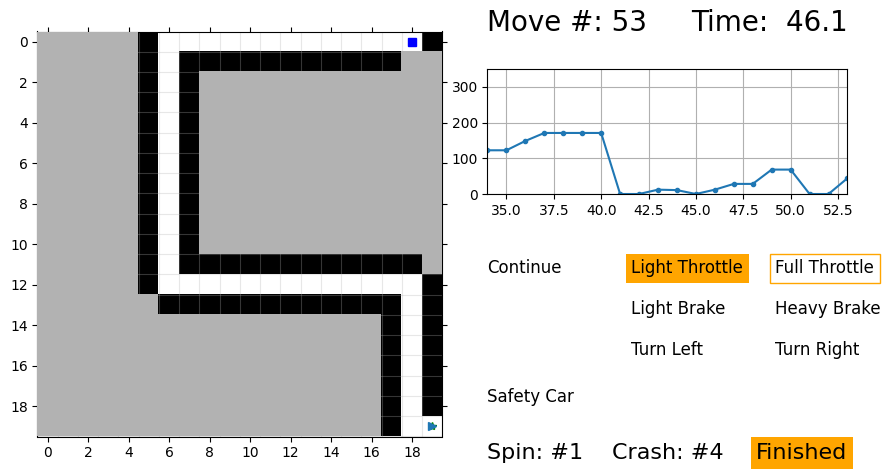

In [3]:
set_seed(0)

# The race method will setup the car and driver for a new race and then call driver.make_a_move repeatedly as the car
# navigates the race. Once the driver reaches the end of the race, or the max_number_of_steps is reached, the function 
# completes.
race(driver, track=track, plot=True, max_number_of_steps=150);       
plt.close()

Well our learner driver got to the end but had a few crashes along the way! Clearly our AI has a few things to learn yet! Let's race several more times on the track and see if the AI gets any better. We can measure the AI's performance by using the "race time" value that is returned by `race`. This is effectively our "lap time" and is the value that will ultimately determine the winner of a race - the AI that completes the race in the shortest time wins. The amount of time that a move takes is related to the car speed, so the faster the AI drives the car, the lower it's race time will be. Crashes add 10 seconds to the race time (which is a lot!), though, so speed needs to be balanced with control - a single crash could knock the driver out of the race lead!

Let's plot how the race time varies as we keep repeating the track.

In [4]:
driver = LearnerDriver(driver_name)             # reset our driver
num_races = 24                                  # number of races to complete, one after another
race_times = np.zeros(num_races)

# Repeat the race num_races times, each time the driver will have learnt more
set_seed(1)
for n in range(num_races):
    driver, race_times[n], _ = race(driver, track=track, plot=False, max_number_of_steps=1000)

# Plot the race time achieved each time
fig = plt.figure(figsize=(9, 5))
plt.plot(range(1, num_races+1), race_times)
plt.ylabel('Race Times', fontsize=16)
plt.xlabel('Number of times we repeated the race', fontsize=16)
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see that the AI rapidly learns to improve its driving after the first race, and converges to a fixed solution - the race times stop improving. Let's see what our AI looks like now on the race track.

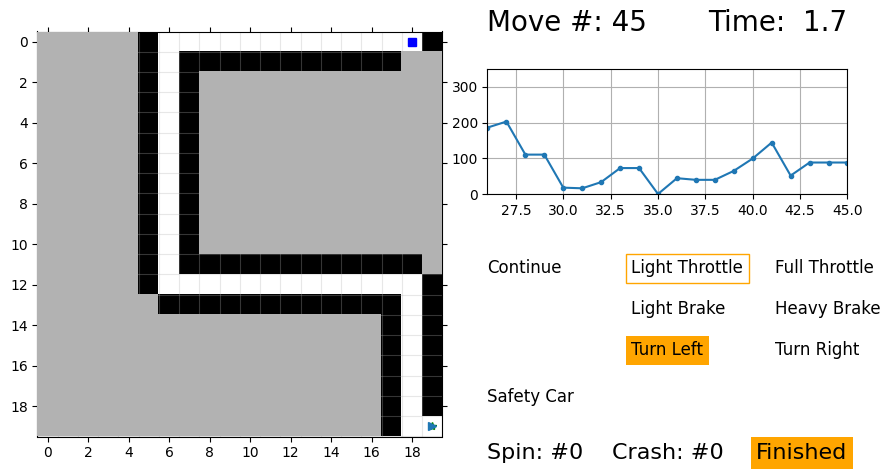

In [5]:
np.random.seed(0)
race(driver, track=track, plot=True, max_number_of_steps=150);
plt.close()

That looked much better, it didn't crash at all! We can analyse our driver's performance in closer detail by running the driver down a simple straight and plotting the actions it takes. To do this, use the `straight_line_sim` method from race control.

<IPython.core.display.Javascript object>


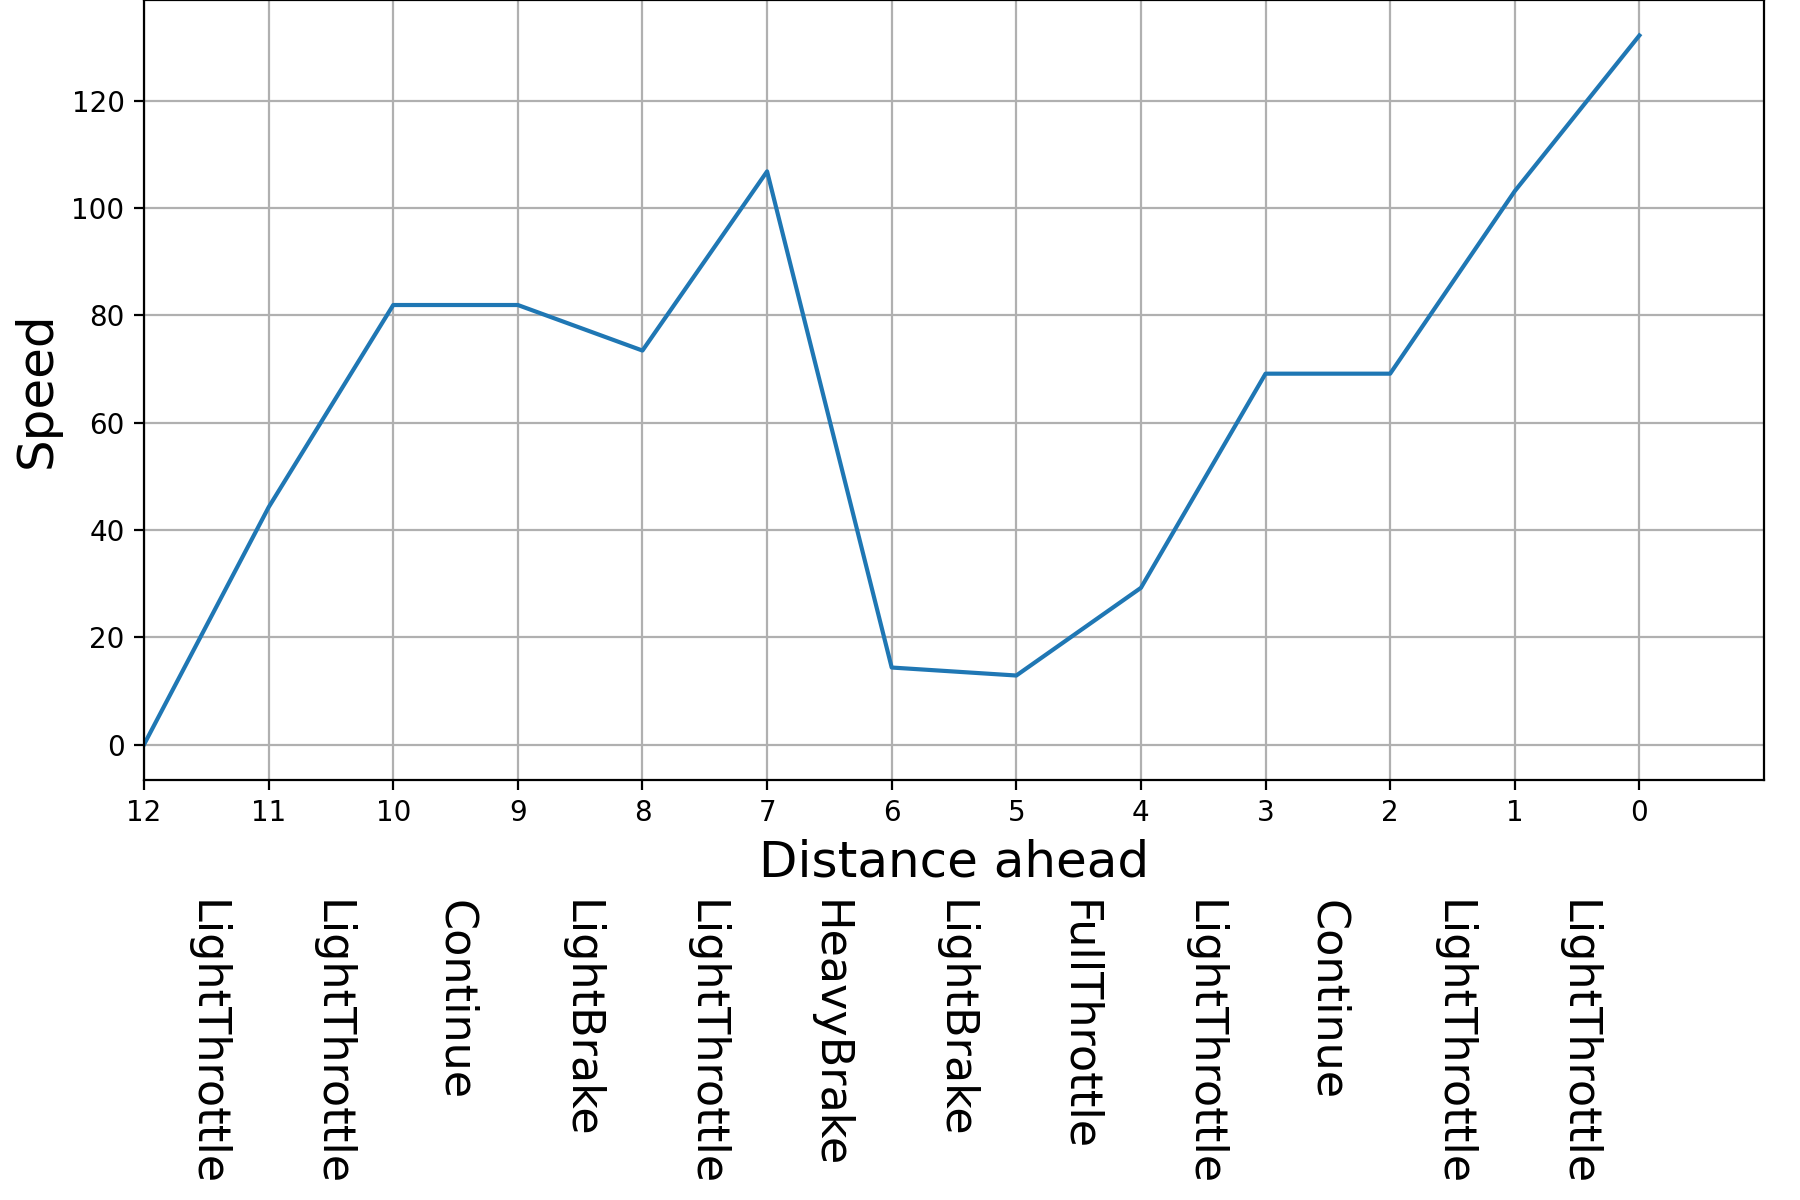

In [8]:
straight_line_sim(driver, level=Level.Learner, straight_length=12, plot=True);

The car starts stationary at the beginning of a straight 12 steps long. We can see that the driver starts off accelerating 
down the straight, which is good, but then things look a little strange. The AI brakes almost to a halt in the middle of the straight before accelerating again. This is definitely not the fastest way to drive! But if the AI can still improve why did it converge to a fixed set of actions rather than continuing to learn more?

This is probably a good point to explain how our driver is learning at the moment. We have used what is perhaps the simplest
form of reinforcement learning: Q Learning. We will cover the basics of the implementation here - there are lots of articles and demos available online if you want to dig deeper into how this works.
 
We first need a definition of our state, that is the values that capture everything our driver needs to know to make a decision. In the case of our learner track, the only thing the driver needs to know is how much distance there is in front of the car before the next turn, and how fast the car is currently travelling. With this information, the driver can decide whether to accelerate (because there is still lots of distance to travel before the corner) or brake because the corner is close and the car is travelling too fast to make the turn.

<p style="text-align: center;"> state  =  [speed, distance_ahead]</p>
 
One issue to deal with is that car speed is a continuous value, but Q Learning relies on us revisiting previous states. To get around this we quantise speed, by default rounding it up to the nearest 10 (1 - 10 -> 10, 11 - 20 -> 20, etc). This gives up some fine control - the driver can't tell the difference between 151 and 159 speed for example. However, it allows the driver to learn with a reasonable number of states.
 
When the driver is asked to decide on the next action to take, it first forms the state vector and then looks for the entry for that state in its Q table. The Q table stores the value that the AI has learnt for taking a particular action in a particular state. The AI will choose to take the action which has the highest Q value for that state. If there are multiple actions all with the same Q value (which is the case at the start when all actions are initialised to have a Q value of 0), the AI will choose one of the actions randomly. 

The Q value is made up of two parts: any immediate reward the AI gets for taking that action in the current state (short term gain), plus the value of being in new state that it ends up in (long term gain). These two parts are traded-off against each other via the `discount_factor`. If the discount factor is high, that is close to 1, then the AI will pay a lot of attention to future rewards; if the discount factor is low, then the AI will focus more on getting short term reward. A lower discount factor can lead to faster and more stable training (especially early on when future rewards are very uncertain) but can prevent the AI from planning ahead and finding the optimal strategy. Finding the right value for this parameter can be important for creating the best AI driver.
  
After making a move the driver is given some feedback as to what happened - the new speed that the car reached and whether
the car spun, crashed, or finished the race. We need to take this information and turn it into a reward for our AI, to 
encourage it to learn to be the best driver it can be. One option is to give the AI a big reward when it completes the race,
and a penalty for every step it takes along the way. This would encourage it to finish as quickly as possible. This suffers
from the *credit assignment problem* however - only receiving a reward at the end of the race will make it very slow for the 
AI to figure out which set of moves along the way were good and which were bad. To help with this we instead use the car
speed as the reward, assuming that the faster the driver can go, the quicker it will reach the end. We also penalise
crashing, as the fastest way to the end definitely doesn't involve having a crash (despite what some racing games suggest). 

We can see inside the AI's 'brain' by plotting the Q table like this,
  

<IPython.core.display.Javascript object>


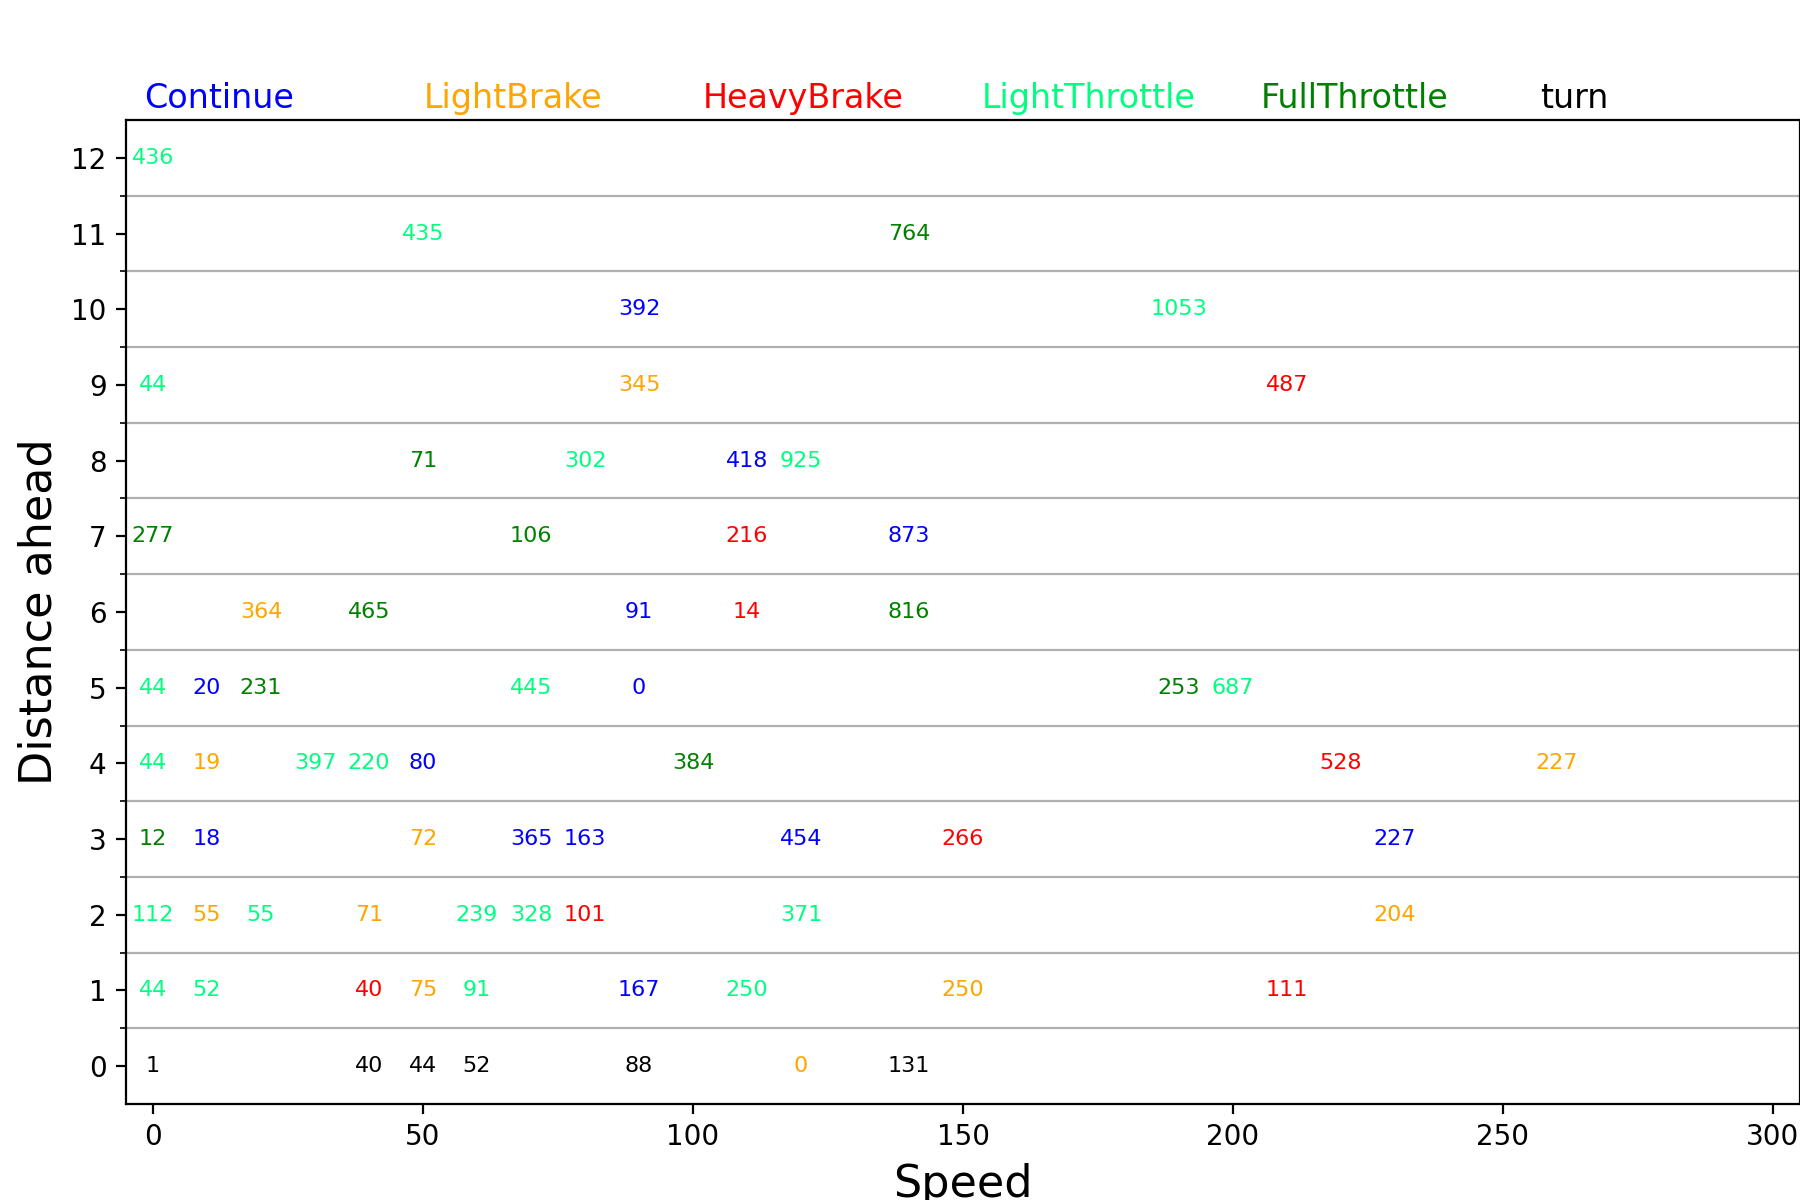

In [9]:
plot_q_table(driver)

This shows the maximum Q value observed in each state, coloured by the action that has this value. Our state is just made
up of two values, which are plotted over the rows and columns. The empty cells are those states that the driver hasn't yet
explored. If the AI had fully explored the space and learnt everything, we would expect to see acceleration actions scoring
highest right up to the last couple of steps before the end of the straight, when the driver would have to brake if the car was 
travelling above the safe cornering speed. We can see that the AI still has much to learn, however it is hard to fully intepret
the Q table as the driver doesn't need to explore the full state space, it just needs to find the optimal route through it
that takes it to the end of the race. It would waste a lot of time exploring every single possibility. This brings us to the exploration - exploitation trade-off, and the reason our AI stopped learning before it reached the best it could be.

Suppose our AI reaches a state for the first time, all the actions in the Q table for that state will be at their default Q values of 0. Because there is no one winning action, the driver will choose randomly from all possible actions. Now suppose that the chosen action leads to an updated Q value that is greater than 0. The next time the AI comes back to the same state and checks the Q table it will find one action with a Q value greater than 0 and all the other actions still at their default 0 value. At the moment our AI will always choose the action with the highest Q value in each state, so it will happily pick the same action it tried previously again. In fact, as long as that action never leads to a crash (which has a negative reward), the AI will never try a different action in that state. This means that once the AI has eliminated crashes it will never explore any other actions and will just keep replaying what it has learnt. It is purely *exploiting* with no *exploration*.

If we want our AI to get better, we need to get it to occaisonally try new actions. A simple way to do this is to introduce a random switch each time the driver has to choose an action. In one setting the AI proceeds as before and uses the Q table to choose its action. In the other setting the driver will instead choose an action randomly and, hopefully, find an even better 
option than it previously knew about. Equally, however, it might accelerate the car into the maze wall - this is the risk of exploration! 
 
Let's investigate this further by having a look at the key parameter controlling this: the `random_action_probability`. When this is set to 0, its default setting, the AI will never take a random action (pure exploitation); if it is set to 1 then it will always take a random action (pure exploration - never using what it has learnt). Let's compare how the AI performs with different settings of this parameter. To do this properly we need to run the races several times using different random numbers each time. This is because a lot of the choices the driver will make involve making a random decision and so the outcomes can vary a lot depending on how lucky our driver is! We want to create an AI that can perform well reliably - drivers that have one amazing race in a season but then crash in all the others will never win the championship!

<IPython.core.display.Javascript object>


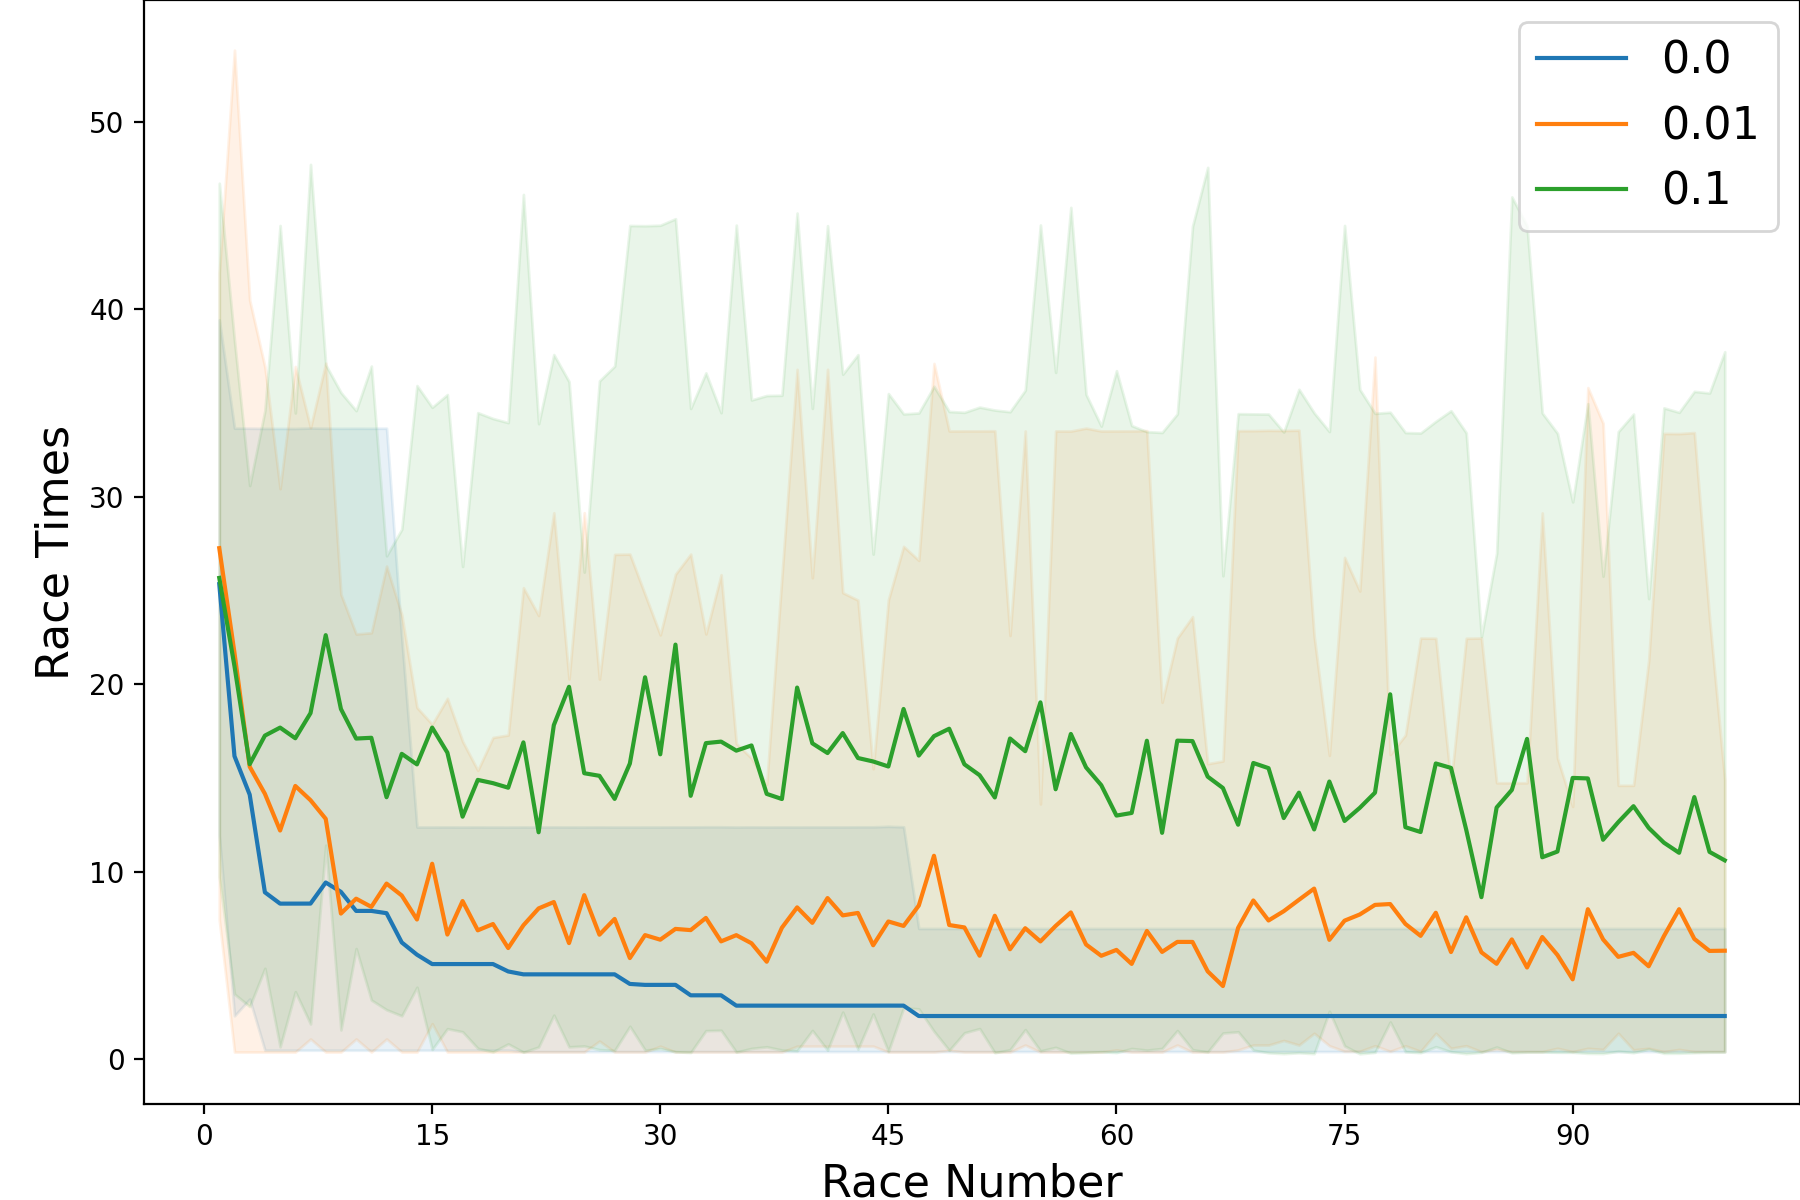

In [10]:
num_races = 100      # number of races over which the AI driver can learn
num_repeats = 20   # number of time to repeat the races, starting from scratch each time, but different random choices
probabilities = [0.0, 0.01, 0.1]
race_times = np.zeros((num_races, num_repeats))
fig = plt.figure(figsize=(9, 6))
fig.add_axes([0.08, 0.08, 0.92, 0.92])
lines = []

for pi in range(len(probabilities)):
    np.random.seed(1)       # for repeatability
    for i in range(num_repeats):
        driver = LearnerDriver(driver_name, random_action_probability=probabilities[pi])        # reset our driver
        for n in range(num_races):
            driver, race_times[n, i], _ = race(driver, track=track, plot=False, max_number_of_steps=1000)
    
    # Plot the results
    lines += plt.plot(range(1, num_races + 1), np.mean(race_times, axis=1))
    plt.fill_between(range(1, num_races + 1), np.min(race_times, axis=1), np.max(race_times, axis=1), 
                     color=lines[-1].get_color(), alpha=0.1)
    
plt.ylabel('Race Times', fontsize=16)
plt.xlabel('Race Number', fontsize=16)
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(lines, probabilities, fontsize=16);

Hm, introducing the random action probability has made things worse - the average performance (solid lines) are worse and the shaded regions (which cover the best to worst performance) are wider for the two drivers which explored. What went wrong?

This is caused by the penalty for crashing, which is very steep compared to the benefit of driving faster. This means that it is much better for our AI to drive slowly and safely rather than exploring a new action and risk crashing. But this is no good! We don't want slow, safe drivers, we want fast skillful drivers! Clearly we need a better way of exploring actions. This type of setup is sometimes called a *cliff-edge loss*, as one wrong step can take you over the edge. This is exactly the situation in Formula 1 - the fastest driver is right on the edge of stability, perfectly taking the car to its limit, without ever straying over the edge. 

There are various ways of building an AI to deal with a cliff-edge loss. One simple thing we can try is to start out with a high probability of taking a random action and reduce it over time. This would allow the AI to explore and learn a lot at the start, when it knows very little and is likely to crash anyway, but then focus its learning around what it has learnt as its knowledge increases. There is a parameter in our Driver class that allows us to do that: `random_action_decay`. Let's try it out.

<IPython.core.display.Javascript object>


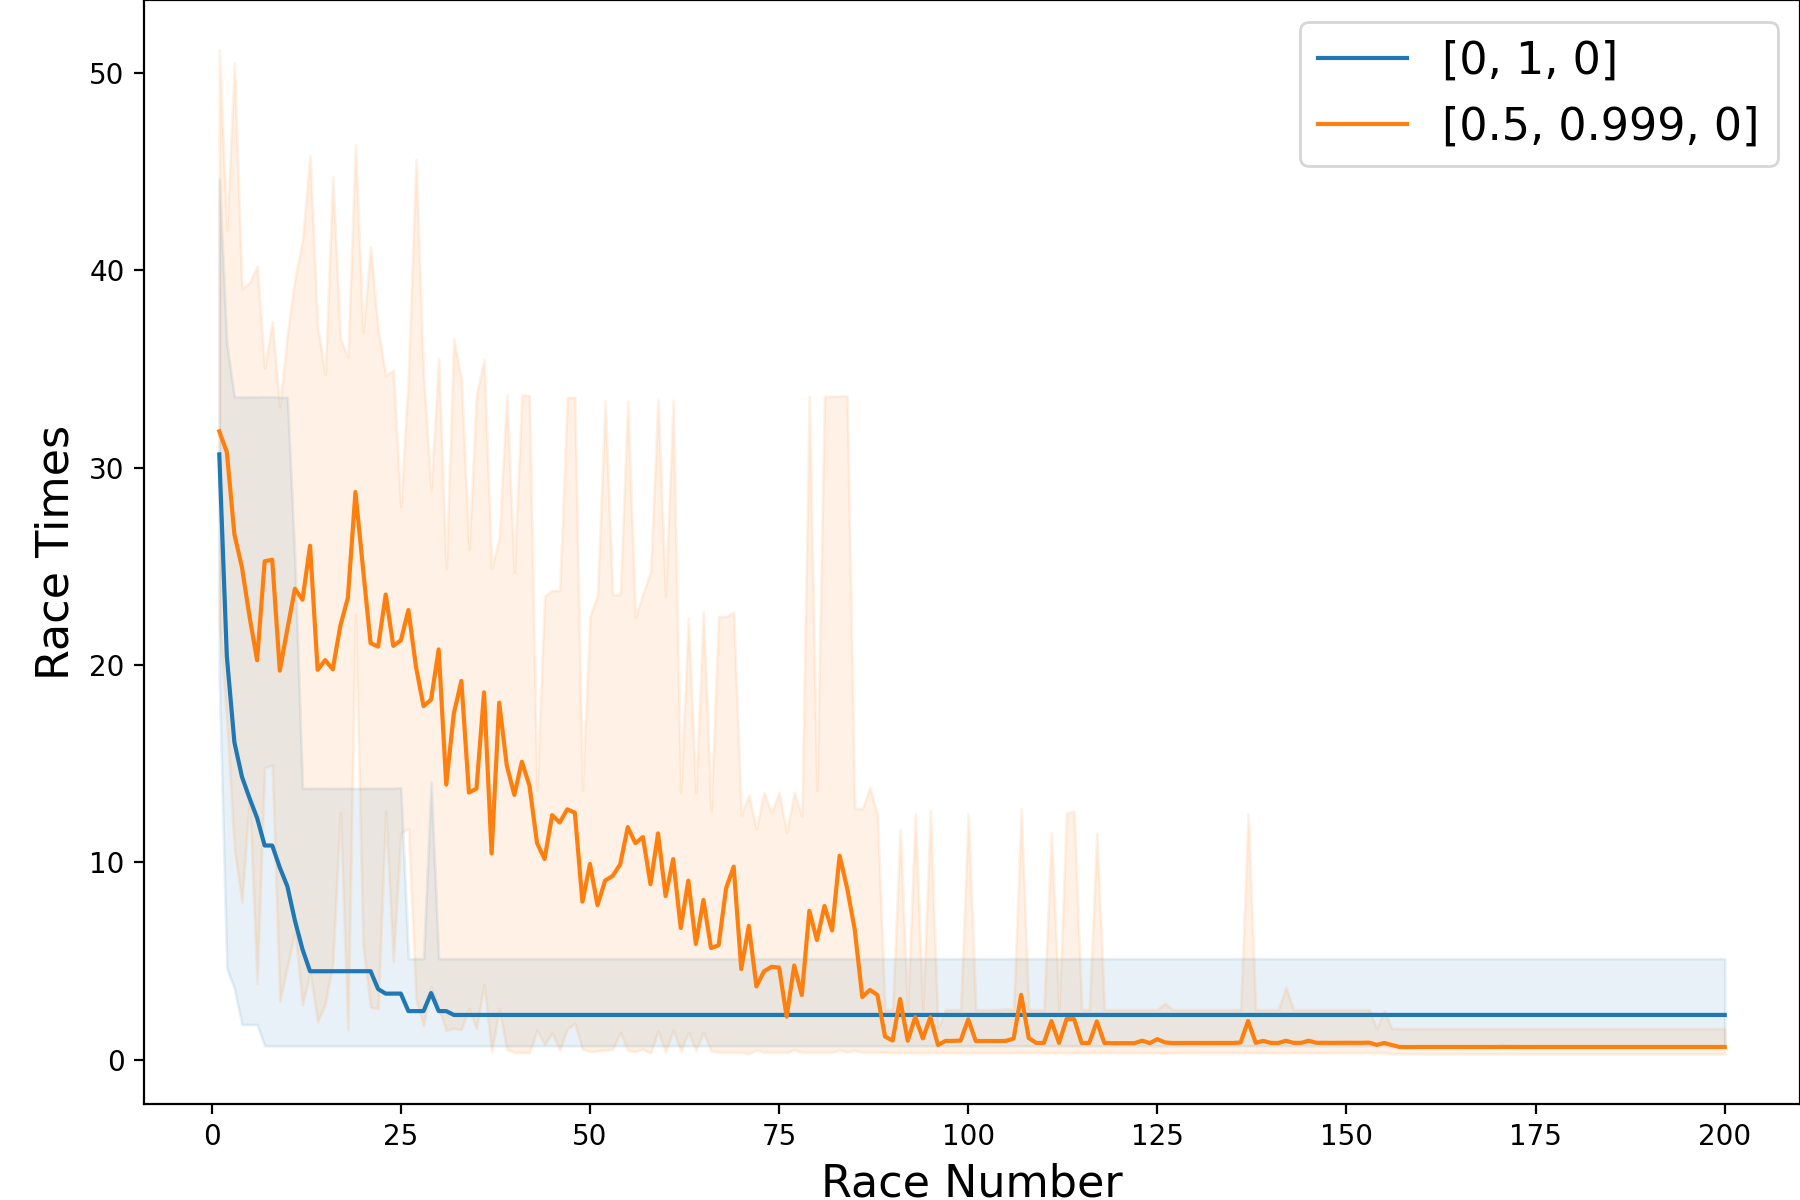

Completed repeat 5/10 for parameter setting 1/2
Completed repeat 10/10 for parameter setting 1/2
Completed repeat 5/10 for parameter setting 2/2
Completed repeat 10/10 for parameter setting 2/2


In [13]:
# This cell can take a while to run depending on the number of races and repeats
num_races = 200      # number of races over which the AI driver can learn
num_repeats = 10   # number of time to repeat the races, starting from scratch each time, but different random choices
param = [[0, 1, 0], [0.5, 0.999, 0]]
race_times = np.zeros((num_races, num_repeats, len(param)))
fig = plt.figure(figsize=(9, 6))
fig.add_axes([0.08, 0.08, 0.92, 0.92])
lines = []

for pi in range(len(param)):
    np.random.seed(0)       # for repeatability
    for i in range(num_repeats):
        driver = LearnerDriver(driver_name, 
                               random_action_probability=param[pi][0], 
                               random_action_decay=param[pi][1],
                               min_random_action_probability=param[pi][2],
                               discount_factor=0.9)        # set up driver with parameters
        for n in range(num_races):
            driver, race_times[n, i, pi], _ = race(driver, track=track, plot=False, max_number_of_steps=1000)
        if np.mod(i + 1, 5) == 0:
            print(f'Completed repeat {i + 1}/{num_repeats} for parameter setting {pi+1}/{len(param)}')
    
    # Plot the results
    lines += plt.plot(range(1, num_races + 1), np.mean(race_times[:, :, pi], axis=1))
    plt.fill_between(range(1, num_races + 1), np.min(race_times[:, :, pi], axis=1), 
                     np.max(race_times[:, :, pi], axis=1), color=lines[-1].get_color(), alpha=0.1)

plt.ylabel('Race Times', fontsize=16)
plt.xlabel('Race Number', fontsize=16)
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(lines, param, fontsize=16);

We can see that initially the driver with 0 random action probability (blue) does a lot better the driver which is exploring (orange). However, once the drivers converge on their best solution the driver which spent more time trying out different actions usually finds a faster way round the track than the driver that just focussed on exploitation. There is a trade-off here then: investing time at the start to explore might lose you championship points in the early races but then gain you points in the later races. Getting this balance right is one of the keys to building a championship winning car!!

There are also other changes we could make to try and improve our AI driver. Rather than choosing each state with the same chance when choosing randomly, we could weight it to focus on the actions with the highest value - allowing exploration but encouraging the driver to test out actions already seen to have some benefit. 

We could also look at the reward scheme we have set up. Changing this can have a large effect on how our driver learns. We might want to reward accelerating at low speed more than at high speed, where it has a smaller effect, for example.

If you want to play further with the driver at this level then feel free to continue here. You can try running over more races or diving in and editing the driver code to make bigger changes - using the sub-class below is one easy way to do this. This is just the intro level however, there are many more challenges available in the next level...so move on up when you are ready!

# We hope to see you in level 2: Young Driver!


# Playground

In [14]:
class MyLearnerDriver(LearnerDriver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def make_a_move(self, car_state: CarState, track_state: TrackState):
        return super().make_a_move(car_state, track_state)
        
    def _choose_randomly(self, available_actions: List[Action]):
        super()._choose_randomly(available_actions)
    
    def update_with_action_results(self, previous_car_state: CarState, previous_track_state: TrackState,
                                   action: Action, new_car_state: CarState, new_track_state: TrackState,
                                   result: ActionResult):
        super().update_with_action_results(previous_car_state, previous_track_state, 
                                           action, new_car_state, new_track_state, result)

my_driver = MyLearnerDriver(driver_name)

In [16]:
race(driver=my_driver, level=Level.Learner)
plt.close()

(<__main__.MyLearnerDriver at 0x197e0e999a0>, 25.72191857733029, True)